In [1]:
import json

In [2]:
asap_output = '../outputs/asap_set2/optimized_relations.json'
asap_data = '../assets/asap_essays.json'

In [4]:
with open(asap_output, "r") as f:
    output = json.load(f)
with open(asap_data, "r") as f1:
    data = json.load(f1)

In [18]:
num_relations = []
scores = []

In [19]:
for d in data.keys():
    if f"{d}.txt" in output.keys():
        scores.append(data[d]['domain1_score'])
        num_relations.append(len(output[f"{d}.txt"]['relations'].keys()))

In [20]:
import matplotlib.pyplot as plt

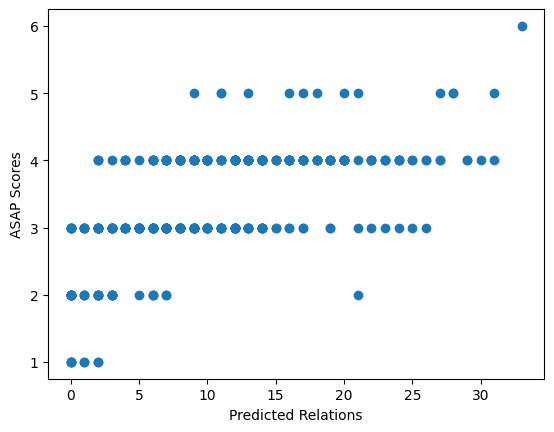

In [52]:
plt.ylabel("ASAP Scores")
plt.xlabel("Predicted Relations")
plt.scatter(num_relations, scores)

In [38]:
import statsmodels.api as sm

In [46]:
model = sm.OLS(scores, num_relations)

In [47]:
results = model.fit()

In [50]:
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.786
Model:                            OLS   Adj. R-squared (uncentered):              0.786
Method:                 Least Squares   F-statistic:                              1469.
Date:                Sat, 18 Nov 2023   Prob (F-statistic):                   7.80e-136
Time:                        11:37:44   Log-Likelihood:                         -756.21
No. Observations:                 400   AIC:                                      1514.
Df Residuals:                     399   BIC:                                      1518.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------